In [6]:
import retinanalysis as ra
import retinanalysis.schema as schema
import retinanalysis.dedup as dd
import numpy as np
import matplotlib.pyplot as plt

### First, let's pull out a dataframe showing noise runs from a specific experiment day. 
### We can choose this day by querying for specific protocols with specific parameters. 

In [9]:
df = ra.get_datasets_from_protocol_names('.SpatialNoise')
df_1 = df[df['exp_name'] == '20250429C']
display(df_1)


Found 2 protocols matching ".spatialnoise":
['manookinlab.protocols.SpatialNoise'
 'manookinlab.protocols.SpatialNoiseAndMotion']

Found 45 experiments, 201 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
172,20250429C,data001,0.5,chunk1,manookinlab.protocols.SpatialNoise,1,20250429C/data001,noise,123,26,2265,3347,477
173,20250429C,data002,0.5,chunk1,manookinlab.protocols.SpatialNoise,1,20250429C/data002,noise,123,26,2265,3348,477
174,20250429C,data010,0.5,chunk2,manookinlab.protocols.SpatialNoise,1,20250429C/data010,noise,123,26,2271,3356,478
175,20250429C,data011,0.5,chunk2,manookinlab.protocols.SpatialNoise,1,20250429C/data011,noise,123,26,2271,3357,478
176,20250429C,data015,1.0,noise30,manookinlab.protocols.SpatialNoise,1,20250429C/data015,30 R* spatial noise,123,26,2275,3361,480


### Let's look at the first datafile from the first chunk.

In [10]:
sb = ra.StimBlock(df_1.at[172, 'exp_name'], df_1.at[172, 'datafile_name'])
ac = ra.AnalysisChunk(df_1.at[172, 'exp_name'], df_1.at[172, 'chunk_name'])

Nearest noise chunk for data001 is chunk1 with distance 0 minutes.

Loading VCD from /Volumes/data/analysis/20250429C/chunk1/kilosort2.5 ...
VCD loaded with 676 cells.
Loaded spatial maps for channels [0, 2] and 676 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.


### Now we can plot the autocorrelation matrix and histograms. Cluster pairs with correlations above threshold are potentially merger targets.

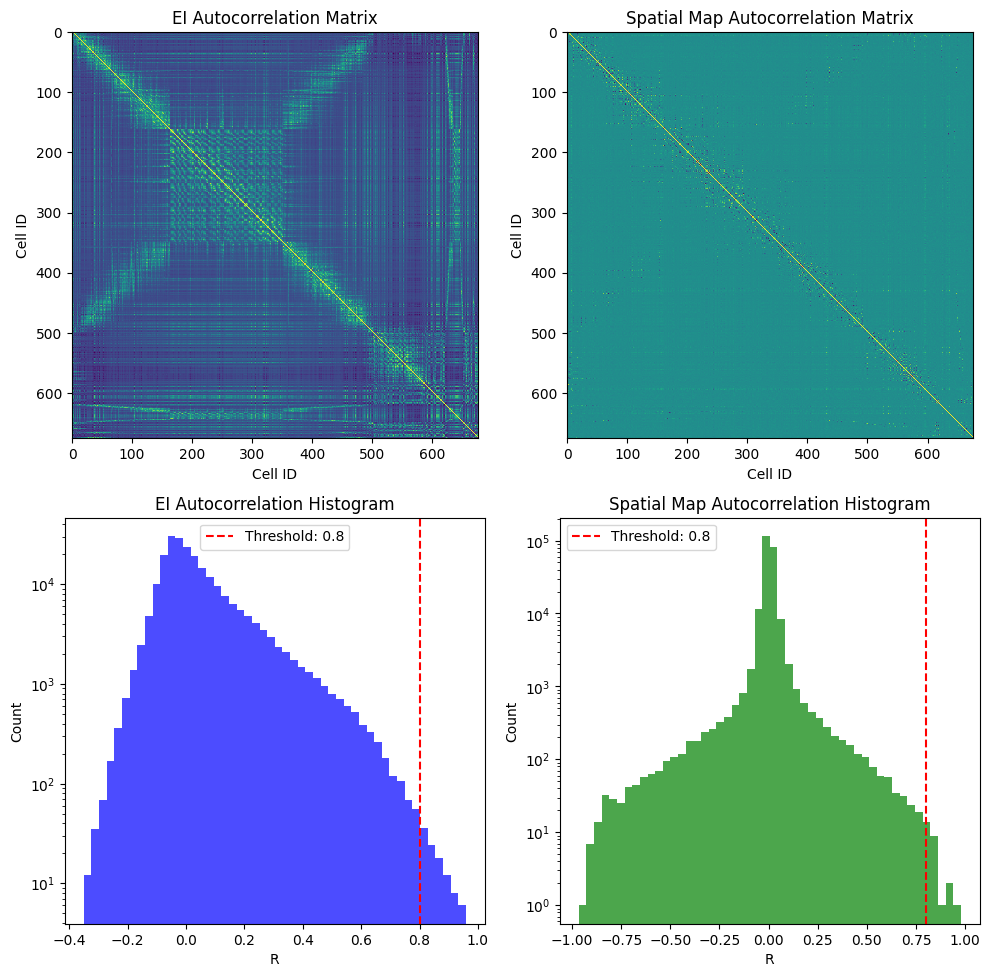

In [15]:
dd.plot_correlations(ac, ei_method='space', ei_threshold=0.8, sm_threshold=0.8);

#### We can also plot our cluster RFs, and highlight those with above-threshold correlations with another cluster.

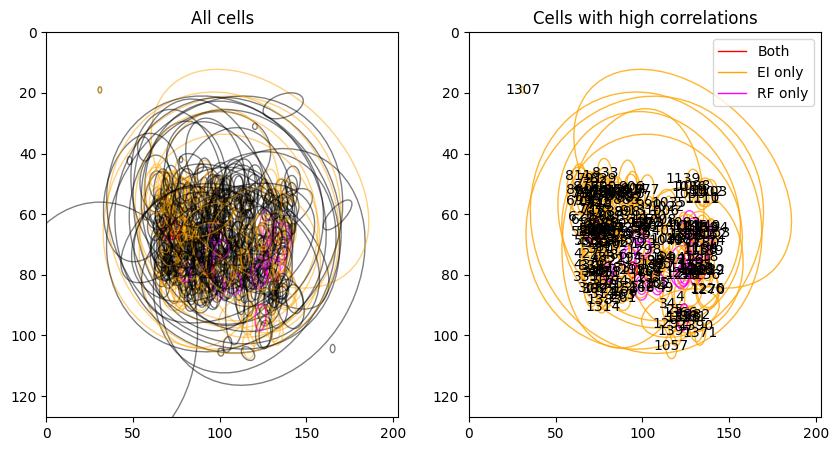

In [19]:
dd.plotRFs_dedup(ac, ei_method='space');

In [21]:
summary_stats, extended_pairs = dd.get_summary_stats(ac, ei_method='space', ei_threshold=0.8, sm_threshold=0.8)
display(summary_stats)

,cluster_a,cluster_b,ei_corr,sm_corr,overlap_fraction
0,639,648,0.852942,0.598659,0.005871
1,1130,1141,0.888377,0.616715,0.491033
2,1083,1084,0.807475,-0.428558,0.533751
3,517,534,0.827533,-0.457382,0.252902
4,517,536,0.829623,-0.179932,0.200777
...,...,...,...,...,...
171,404,1314,0.842339,0.030386,0.038310
172,404,1383,0.759245,-0.033374,0.057395
173,405,1314,0.741747,0.021261,0.006131
174,405,1383,0.588381,-0.020953,0.019876


#### Do we have any cluster pairs with above threshold correlations in both categories?

In [26]:
_, high_sm_pairs = dd.get_sm_autocorrelation(ac)
_, high_ei_pairs = dd.get_ei_autocorrelation(ac, ei_method='space')
intersected_pairs = high_ei_pairs.intersection(high_sm_pairs)
print(f"Number of pairs in both categories: {len(intersected_pairs)}")

Number of pairs in both categories: 2


#### Let's see if the clusters in the pairs in both categories are highly correlated with any other cells.

In [34]:
#collapse members of both tuples into a single set using list comprehension without tuples
high_corr_cells = set([item for pair in intersected_pairs for item in pair])

for cell in high_corr_cells:
    dfx = summary_stats.query('cluster_a == @cell or cluster_b == @cell')
    if len(dfx.index) > 1:
        print(f"Cell {cell} has multiple entries in summary stats:")
        display(dfx)

In [37]:
display(summary_stats.query('cluster_a in @high_corr_cells or cluster_b in @high_corr_cells'))

,cluster_a,cluster_b,ei_corr,sm_corr,overlap_fraction
79,568,596,0.916573,0.918686,0.999702
164,199,212,0.955361,0.919182,0.990300


#### Looks like not. So let's just visualize our pairs. If we had a larger group of related cells, we could visualize that also.

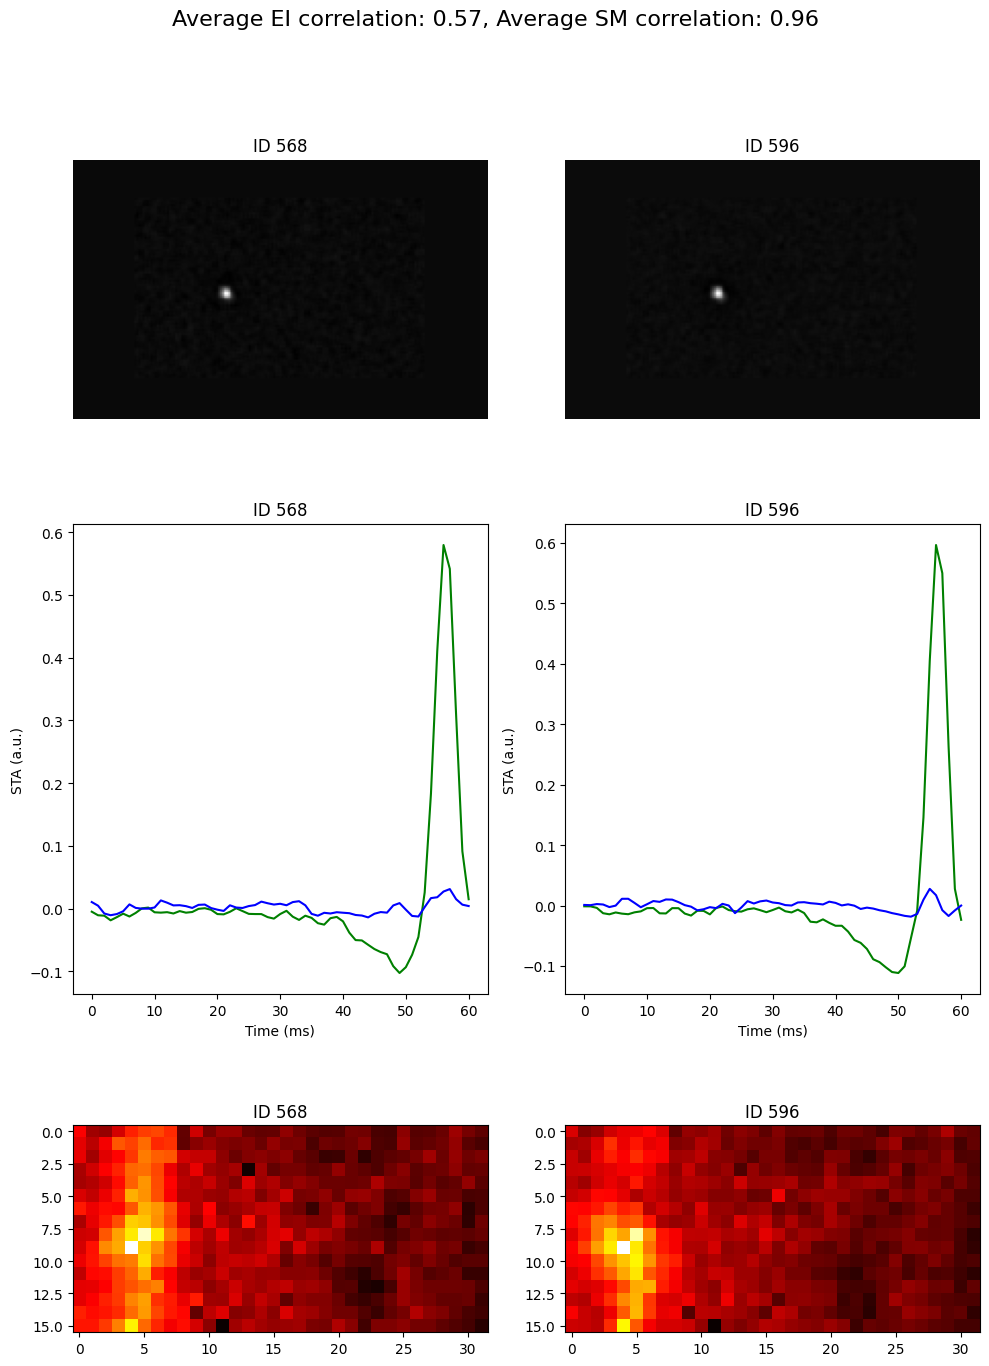

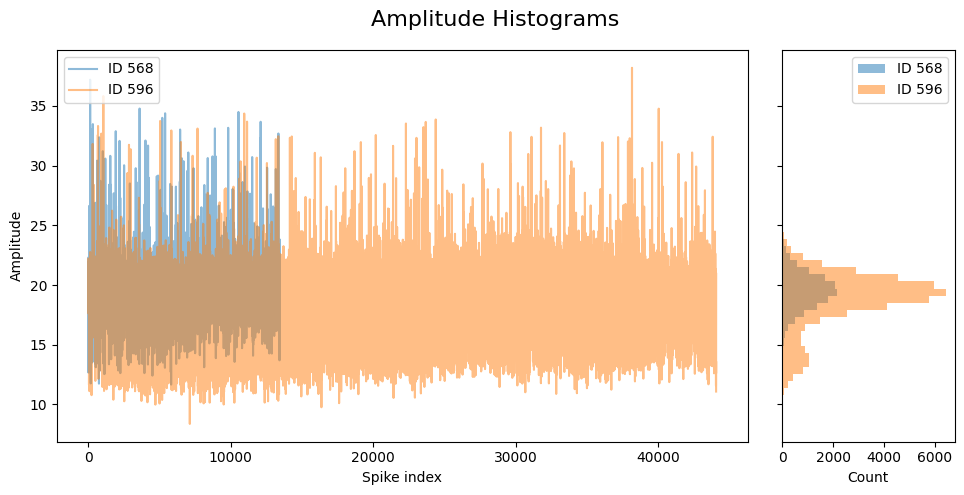

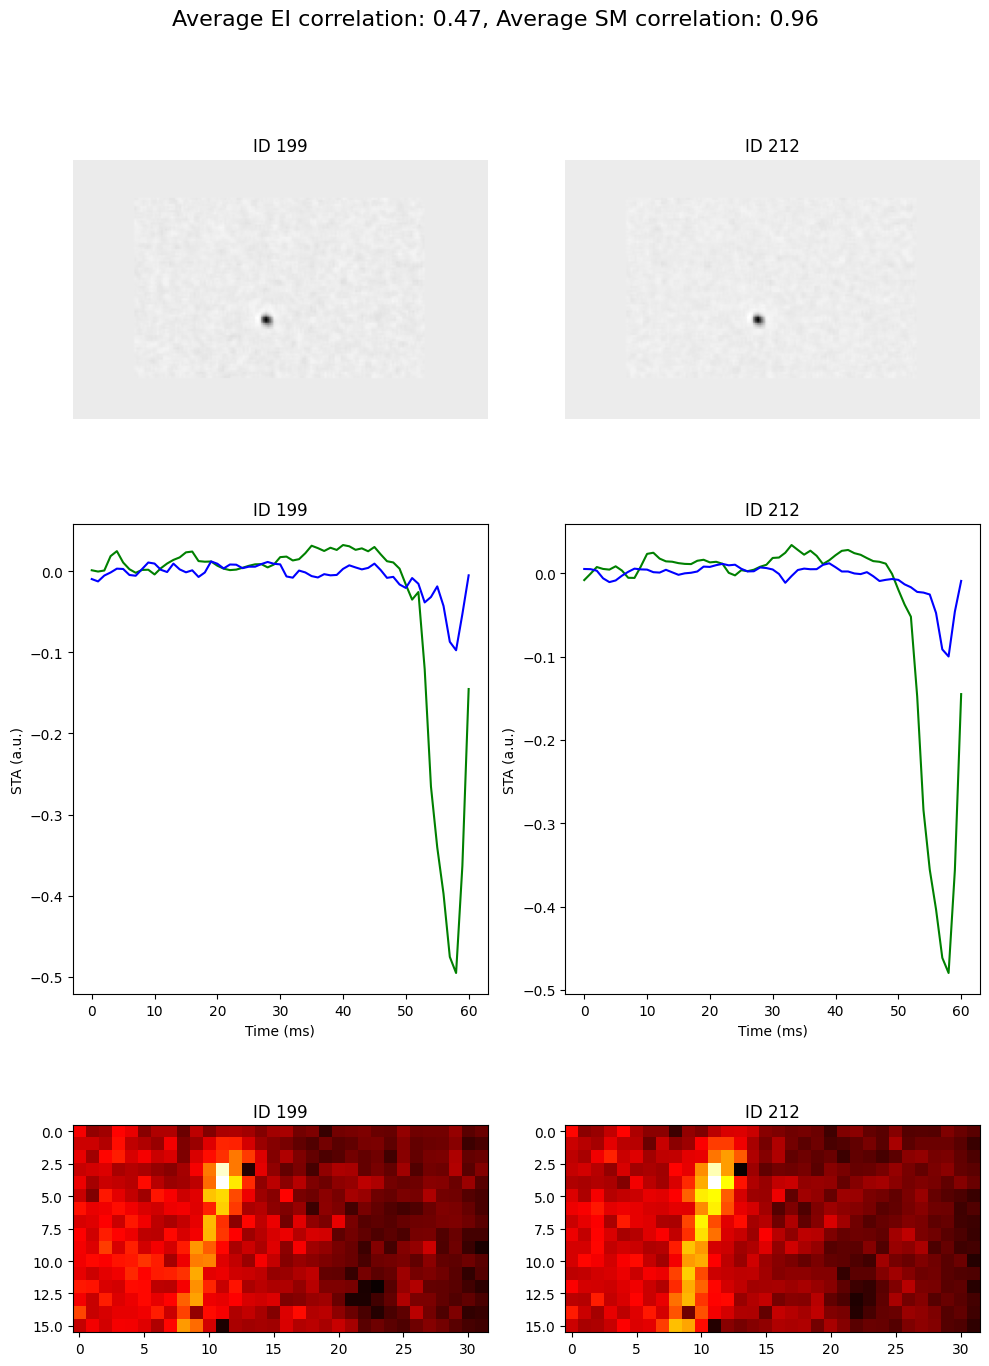

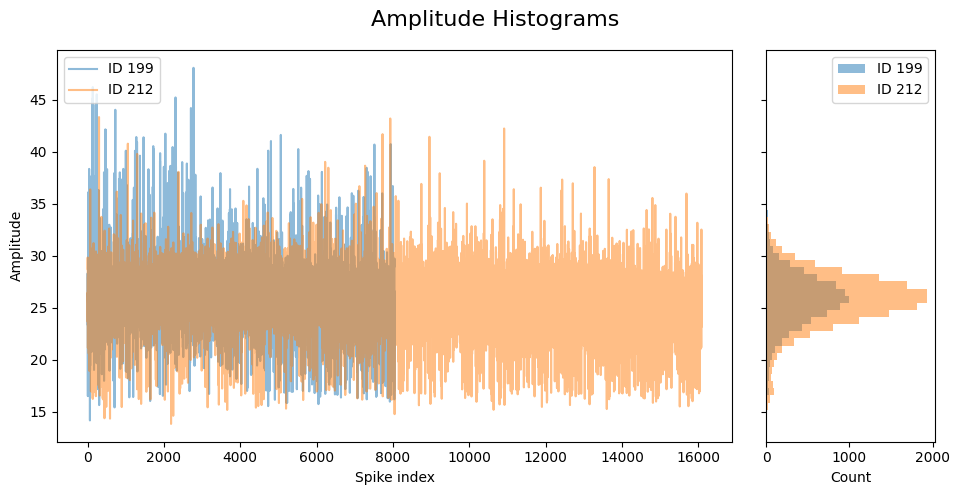

In [36]:
for pair in intersected_pairs:
    dd.visualize_groups(pair, ac, detailed=False);
    dd.plot_amplitude_histograms(ac, pair);

Both of these pairs have high overlap in amplitude histograms, and highly correlated spatial map and EI (at least using EI collapsed across time). They appear to be the same type based on timecourse.

199 and 212 are good candidates for merging. Cell 596 appears to possibly need to be split (bimodal amplitude distribution) and also is a good candidate for merging with cluster 568.

Note that both cluster pairs are midgets - midget clusters that are the same seem to often have low EI correlations unless collapsing time.